# TensorFlow Script Mode - Using Shell commands

Starting by TensorFlow's framework version 1.11, you can shell commands as
your training entry point. Shell scripts are useful for many use cases including:

- Invoke Python scripts with specific parameters
- Install requirements before training
- Configure framework dependencies
- Train using different computer languages

For this example, you use [a Keras implementation of the Deep Dream algorithm](https://github.com/keras-team/keras/blob/2.2.4/examples/deep_dream.py). You can use the same technique for other scripts or repositories. For example, [TensorFlow Model Zoo](https://github.com/tensorflow/models) and [TensorFlow benchmark scripts](https://github.com/tensorflow/benchmarks/tree/master/scripts/tf_cnn_benchmarks).

# Getting the image for training
For training data, let's download an open sourced image:

In [ ]:
import os
data_dir = os.path.join(os.getcwd(), 'training')

os.makedirs(data_dir, exist_ok=True)
data_dir

In [ ]:
!wget -O training/resting-dragon.jpg https://s3.amazonaws.com/wyspstore/1360008n.jpg

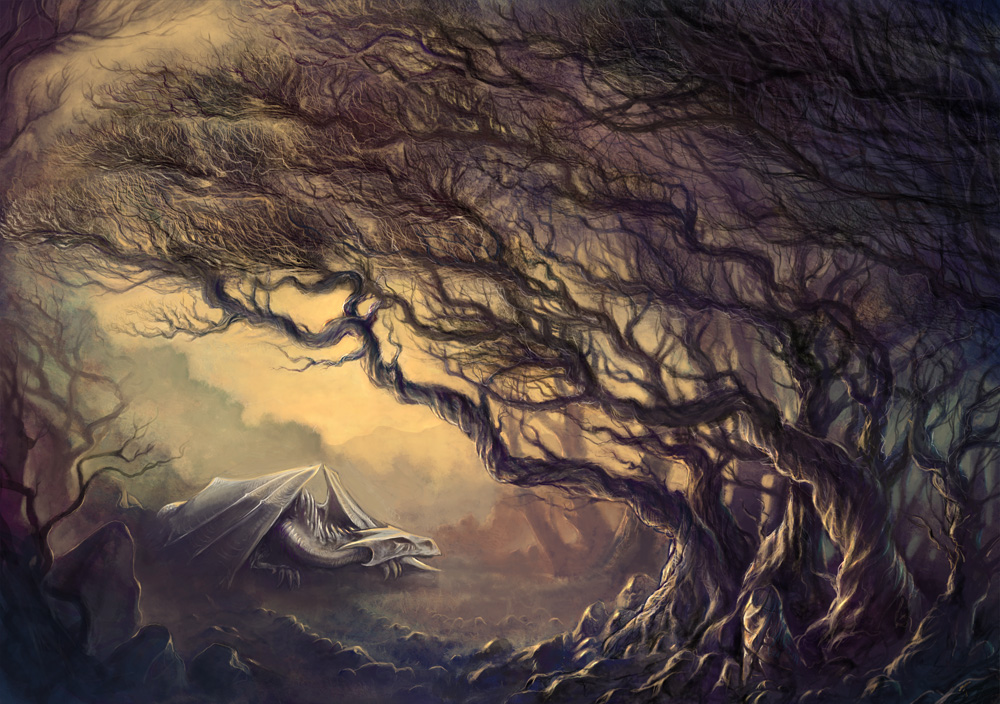

In [58]:
from IPython.display import Image
Image(filename='training/resting-dragon.jpg') 

## Download the training script

Let's start downloading the training script:

In [ ]:
!wget https://raw.githubusercontent.com/keras-team/keras/2.2.4/examples/deep_dream.py

The script **deep_dream.py** takes two positional arguments:
- `base_image_path`: Path to the image to transform.
- `result_prefix`: Prefix of all generated images.

### Creating the launcher script

We need to create a launcher script that install Keras, sets `base_image_path` 
and `result_prefix`, and invokes **deep_dream.py**:

In [ ]:
%%writefile launcher.sh 

pip install keras==2.2.4

BASE_IMAGE_PATH="${SM_CHANNEL_TRAINING}/resting-dragon.jpg"
RESULT_PREFIX="${SM_MODEL_DIR}/dream"

python deep_dream.py ${BASE_IMAGE_PATH} ${RESULT_PREFIX}

echo "Generated image $(ls ${SM_MODEL_DIR})"

**SM_CHANNEL_TRAINING** and **SM_MODEL** are environment variables created by the SageMaker TensorFlow
Container in the beggining of training. Let's take a more detailed look at then: 

- **SM_MODEL_DIR**: the directory inside the container where the training model data must be saved inside the container, i.e. /opt/ml/model.
- **SM_TRAINING_CHANNEL**: the directory containing data in the 'training' channel. For more information about training environment variables, please visit [SageMaker Containers](https://github.com/aws/sagemaker-containers#list-of-provided-environment-variables-by-sagemaker-containers).

## Test locally using SageMaker Python SDK TensorFlow Estimator

You can use the SageMaker Python SDK [TensorFlow](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/README.rst#training-with-tensorflow) estimator to easily train locally and in SageMaker. To train locally, you can set the instance type to [local](https://github.com/aws/sagemaker-python-sdk#local-mode) as follow:

In [ ]:
import sagemaker
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(entry_point='launcher.sh',
                       dependencies=['deep_dream.py'],      # Including deep_dream.py as a dependency
                       train_instance_type='local',         # Run in local mode
                       train_instance_count=1,
                       role=sagemaker.get_execution_role(), # Passes to the container the AWS role that you are using on this notebook
                       framework_version='1.11.0',          # Uses TensorFlow 1.11
                       py_version='py3',
                       script_mode=True)

To start a training job, we call `estimator.fit(inputs)`, where inputs is a dictionary where the keys, named **channels**, have values pointing to the data location:

In [ ]:
inputs = {'training': f'file://{data_dir}'}

estimator.fit(inputs)

`estimator.model_data` contains the S3 location where the contents of **/opt/ml/model**
were save as tar.gz file. Let's untar and download the model:

In [ ]:
!aws s3 cp {estimator.model_data} model.tar.gz
!tar -xvzf model.tar.gz

We can see the resulting image now:

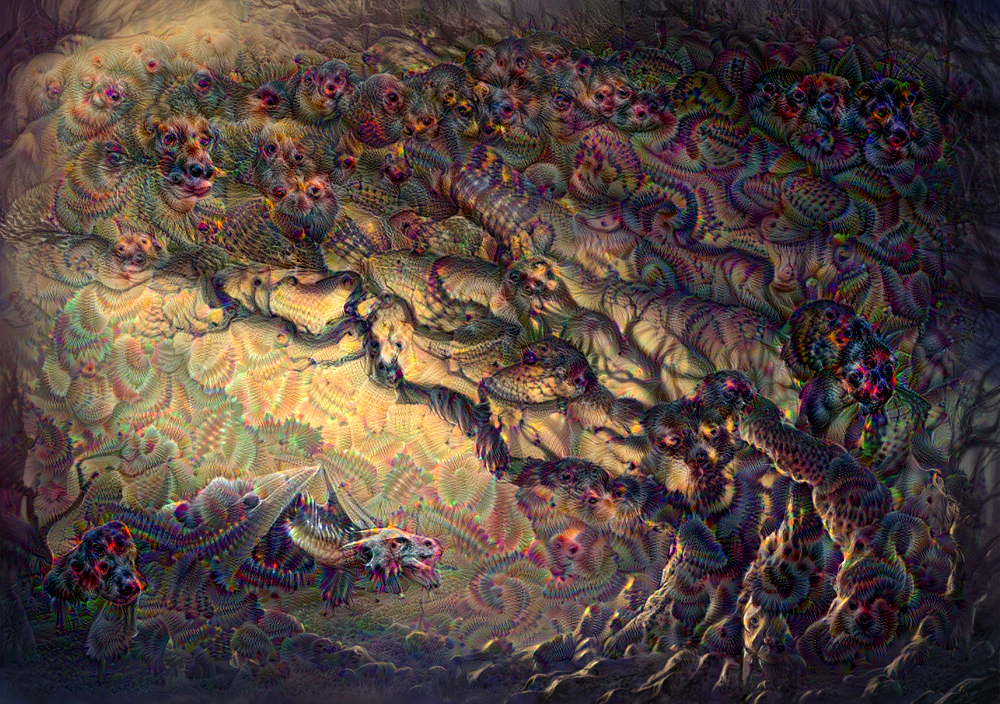

In [63]:
from IPython.display import Image
Image(filename='dream.png')

# Training in SageMaker

After you test the training job locally, upload the dataset to an S3 bucket so SageMaker can access the data during training:

In [ ]:
import sagemaker

training_data = sagemaker.Session().upload_data(path='training', key_prefix='datasets/deep-dream')

The returned variable inputs above is a string with a s3 location which SageMaker Tranining has permissions
to read data from. **It has education purposes, requiring
 more robust solutions for larger datasets:**

In [ ]:
training_data

To train in SageMaker:
- change the estimator argument **train_instance_type** to any SageMaker ml instance available for training.
- set the **training** channel to a S3 location.

For example:

In [ ]:
estimator = TensorFlow(entry_point='launcher.sh',
                       dependencies=['deep_dream.py'],
                       train_instance_type='ml.c4.xlarge', # Executes training in a ml.c4.xlarge instance
                       train_instance_count=1,
                       role=sagemaker.get_execution_role(),
                       framework_version='1.11.0',
                       py_version='py3',
                       script_mode=True)
             

estimator.fit(training_data) # Starts training and creates a data channel named 
# training with the contents of data dir